<a href="https://colab.research.google.com/github/Ovrup/EVA-/blob/master/EVA_Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing all necessary keras Modules
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,Callback
from keras.callbacks import ModelCheckpoint
import tempfile
from keras import backend as K
import cv2
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
from google.colab import drive,files

drive.mount('/content/drive')
path = '/content/drive/My Drive/'

base_dir = path + 'EVA Assignment 11/Model_Weight_11/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Download the CIFAR10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


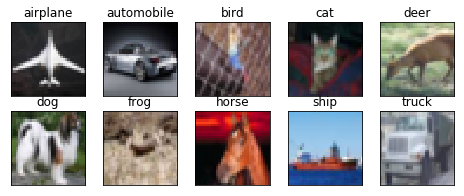

In [4]:
# Visualization of images from dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Function defined for plotting the model history i.e epoch vs validation accuracy & epoch vs validation loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    print('Top validation accuracy = %0.2f'%max(model_history.history['val_acc']))
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# As shown above the label matrix(train_features & test_features) holds the images. So, keras may find some relational order
# between these values. To avoid this problem we hot encode the matrix into a binary matrix. This matrix has number of columns equal to the number
# of classes(10 columns in this scenario). Each row defines the label of one sample point in data set & has only one '1' & others are '0'.
# Convert 1-dimensional class arrays to 10-dimensional class matrices
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels_hot = np_utils.to_categorical(train_labels, num_classes)
test_labels_hot = np_utils.to_categorical(test_labels, num_classes)

In [8]:
# Define the model
model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Convolution2D(256, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))

model.add(Convolution2D(128, 1, 1, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Convolution2D(128, 3, 3 , border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))

model.add(Convolution2D(10, 1, 1, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(10, 8, 8))

model.add(Flatten())

model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer=SGD(momentum = 0.8), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8))`


In [9]:
# summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)      

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
    

        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
# Create object of LR_Finder class
batch_size = 128
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/batch_size))

In [0]:
# callback for learning rate finder
callbacks_list = [lr_finder]

In [0]:
# Function to implement cutout(random erasing)
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  
    def eraser(input_img):
      
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
weightsFile = tempfile.mkstemp()[1]
model.save_weights(weightsFile)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.2, shear_range = 0.2, rotation_range = 5,
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels_hot, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 5, verbose = 0,
                                 validation_data = (test_features, test_labels_hot), callbacks = callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., verbose=0, validation_data=(array([[[..., callbacks=[<__main__..., steps_per_epoch=390, epochs=5)`
  # Remove the CWD from sys.path while we load stuff.


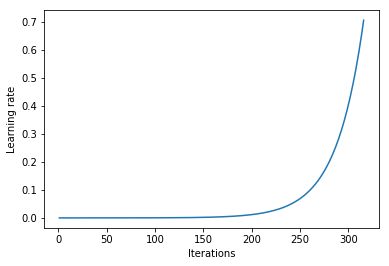

In [16]:
lr_finder.plot_lr()

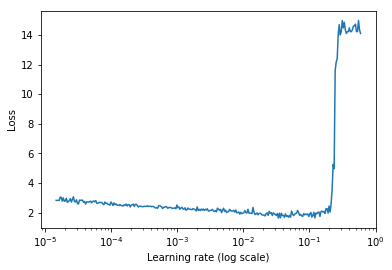

In [17]:
lr_finder.plot()

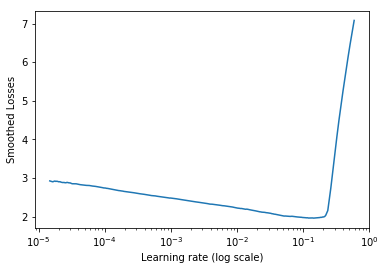

In [18]:
lr_finder.plot_smoothed_loss()

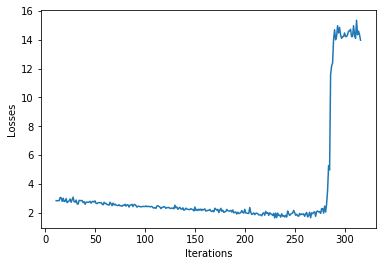

In [19]:
lr_finder.plot_loss()

In [0]:
model.load_weights(weightsFile)

In [0]:
# Defined function for learning rate schedule
def scheduler(epoch,lr):
  decay = 0.1
  return round(0.04 * (1 / (1 + decay * epoch)) , 10)

In [0]:
# Compile the model
model.compile(optimizer=SGD(lr = 0.04, momentum = 0.8), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# checkpoint. Saves the best model
filepath = base_dir + 'weights-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list_2 = [checkpoint, LearningRateScheduler(scheduler,verbose = 0)]

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.2, shear_range = 0.2, rotation_range = 5,
                             horizontal_flip=False, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels_hot, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, verbose = 0,
                                 validation_data = (test_features, test_labels_hot), callbacks = callbacks_list_2)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels_hot, model))

In [0]:
# Evaluate the model on weights saved for the best model
score = model.evaluate(test_features, test_labels_hot, verbose = 0)

In [0]:
# Load saved model to get the top accuracy
model.load_weights(filepath)
# Compile the model
model.compile(optimizer=SGD(lr = 0.04, momentum = 0.8), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Evaluate the model on weights saved for the best model
top_score = model.evaluate(test_features, test_labels_hot, verbose = 0)

In [26]:
# Print the top accuracy
print(top_score)

[0.5035853062272072, 0.8532]


##**Finding out 25 misclassified image**

In [0]:
# Prediction of classes for the test images
preds = model.predict_classes(test_features)

In [0]:
# Below code gets the indices of that images which are wrongly classified by the model & selected the 1st 25 indices. Based on the
# indices the respective 25 missclassified images are picked from test data
missclassified_index = [idx for idx,i in enumerate(preds) if i != test_labels[idx,0]]
missclassified_index = missclassified_index[:25]
missclassified_image = np.array([test_features[i] for i in missclassified_index])

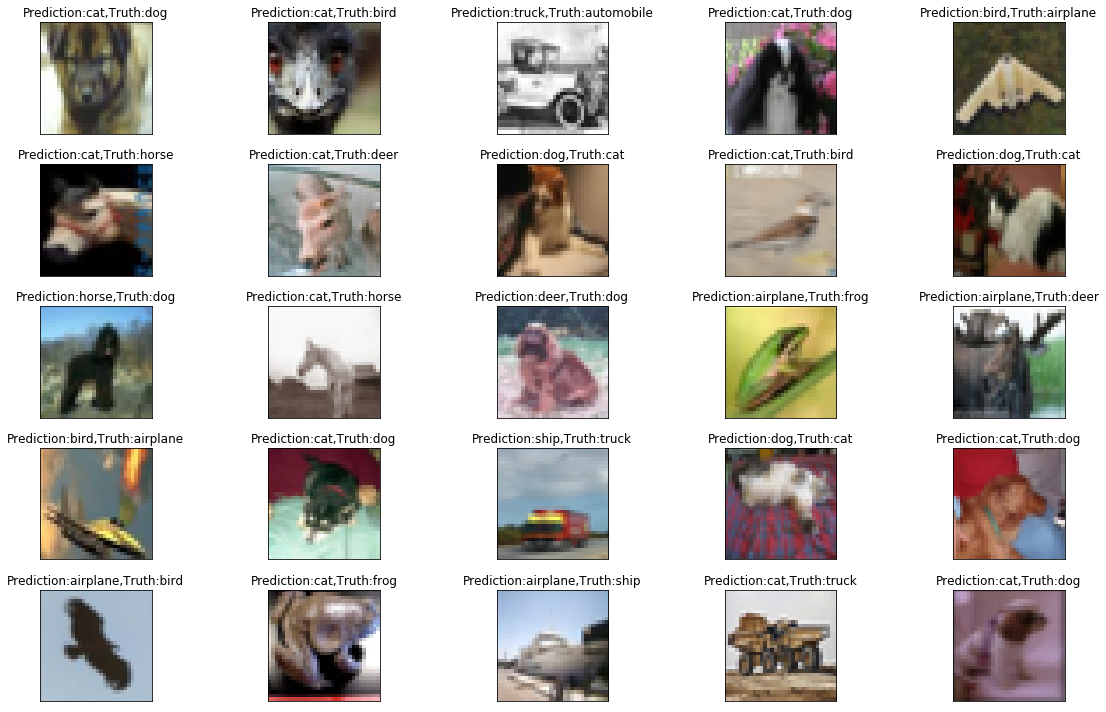

In [29]:
# Displaying the 25 missclassified images with prediction & ground truth label
row_size = 5
col_size = 5
image_index = 0
fig = plt.figure(figsize=(16, 10))  # figure size in inches

for j in range(col_size*row_size):
  ax = fig.add_subplot(row_size, col_size, j + 1, xticks=[], yticks=[])
  ax.imshow(missclassified_image[j])
  plt.title(f'Prediction:{class_names[preds[missclassified_index[j]]]},Truth:{class_names[test_labels[missclassified_index[j]][0]]}')
  
plt.tight_layout()

In [31]:
# Prediction for missclassified images by the trained model created
pred_cam = model.predict(missclassified_image)
print(f'Type of pred_cam : {type(pred_cam)}')
print(f'Shape of pred_cam : {pred_cam.shape}')
# Fetch the index of the classes predicted by the model
class_idxs = np.argmax(pred_cam,axis=-1)
print(f'Class indices : {class_idxs}')
print(f'Shape of class indice : {class_idxs.shape}')
print(f'Type of class indices : {type(class_idxs)}')
# Get the predicted value of the classes
for i in range(class_idxs.shape[0]):
  class_output = model.output[:,class_idxs[i]]
print(f'Type of class output : {type(class_output)}')
# Output of the selected layer on wich Grad-CAM will be applied
layer_cam = model.get_layer('conv2d_7')
print(f'Type of layer_cam : {type(layer_cam)}')

Type of pred_cam : <class 'numpy.ndarray'>
Shape of pred_cam : (25, 10)
Class indices : [3 3 9 3 2 3 3 5 3 5 7 3 4 0 0 2 3 8 5 3 0 3 0 3 3]
Shape of class indice : (25,)
Type of class indices : <class 'numpy.ndarray'>
Type of class output : <class 'tensorflow.python.framework.ops.Tensor'>
Type of layer_cam : <class 'keras.layers.convolutional.Conv2D'>


In [32]:
# Calculate the gradient of the class outputs w.r.t output of the selected layer
grads = K.gradients(class_output,layer_cam.output)[0]
print(f'grads shape:{grads.shape}')
# Global Average Pooling on the calculated gradient channels
pooled_grads = K.mean(grads,axis=(0,1,2))
print(f'pooled_grads shape:{pooled_grads}')

iterate = K.function([model.input], [pooled_grads, layer_cam.output[0]])
pooled_grads_value,layer_cam_value = iterate([missclassified_image])

superimposed_img_list = []
missclassified_image_RGB_list = []

# Weigh the layer output with the pooled gradient channels
for j in range(128):
  layer_cam_value[:,:,j] *= pooled_grads_value[j]

for i in range(25):
  heatmap = np.mean(layer_cam_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  # Superimpose the heatmap with the images missclassified
  superimposed_img = cv2.addWeighted(missclassified_image[i], 1, heatmap, 1, 0, dtype = cv2.CV_32F )
  superimposed_img_list.append(superimposed_img)
  missclassified_image_RGB = cv2.cvtColor(missclassified_image[i],cv2.COLOR_BGR2RGB)
  missclassified_image_RGB_list.append(missclassified_image_RGB)


grads shape:(?, 16, 16, 128)
pooled_grads shape:Tensor("Mean:0", shape=(128,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

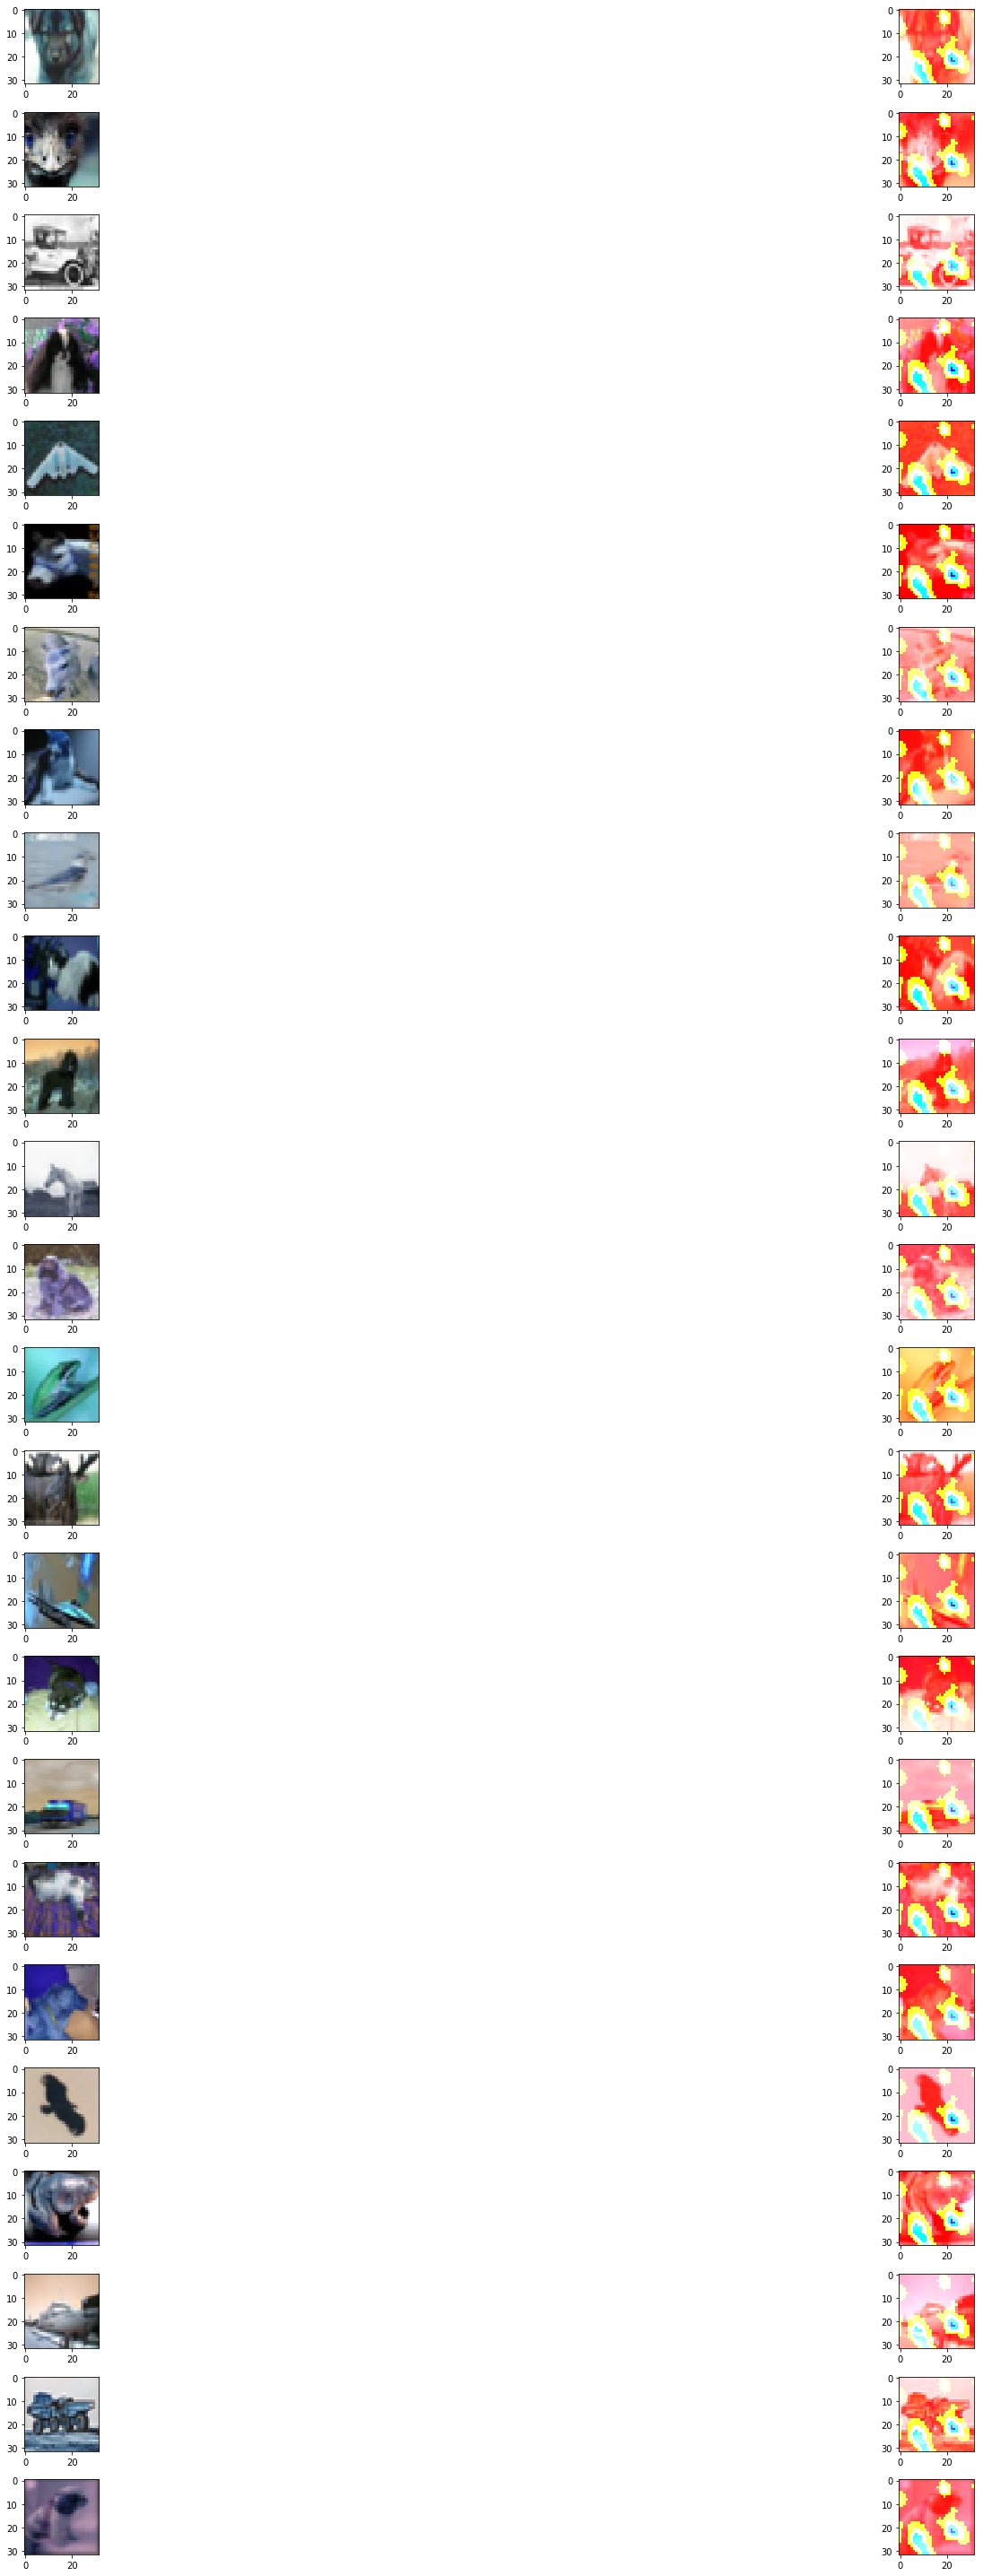

In [33]:
# Display the missclassified image & the superimposed image
row_num = 25
col_idx = 0
fig, ax = plt.subplots(row_num, 2,figsize=(40,40))
for row in range(row_num):
  ax[row][col_idx].imshow(missclassified_image_RGB_list[row])
  col_idx+=1
  ax[row][col_idx].imshow(superimposed_img_list[row])
  col_idx-=1
plt.tight_layout()